# Results for TSMCN-8-L-229 with Pytorch


In [32]:
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator
import numpy as np
from numpy import asarray
import pandas as pd
import math
import seaborn as sns  #heat map
import glob # batch processing of images


import matplotlib.font_manager as fm
import random
import sys
import os

from sklearn.datasets import make_regression
import tensorflow as tf
from sklearn.metrics import confusion_matrix    #confusion matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Collect all the font names available to matplotlib
font_names = [f.name for f in fm.fontManager.ttflist]
# print(font_names)

from scipy import signal
from scipy import interpolate

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve 
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score


from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF

#Sklearn model saving and loading
from joblib import dump, load

if '../../' not in sys.path:
    sys.path.append('../../')

from aimos.spectral_datasets.THz_datasets import THz_data

from aimos.misc.utils import simple_plotter


#Set random seed
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_seed(42)  
tf.random.get_global_generator().reset_from_seed(42)
np.random.seed(42)
random.seed(42)



In [33]:
from oneida import THz_mixture_data
from oneida_utils import concentrations_to_one_hot_encode, create_mixture_names

# Retrieve training(D)+ validation(V) mixtures and its variables

In [34]:
TAAT = 0.001 
ASAT=0.01
# ASAT=0.005
RSAT=0.05
# RSAT=0.005

In [35]:
m = THz_mixture_data(resolution=0.016, pressure='1 Torr', verbosity=False)
m.initiate_THz_mixture_data(TAAT = TAAT, 
                               ASAT=ASAT, 
                               RSAT=RSAT)

reduced_labels = m.labels
reduced_labels.remove('')
reduced_labels.remove(' ')
reduced_labels.remove('Diluent')
print(reduced_labels)


Components :  [[0 1 2 3 4 5 6 7 8]]
Components shape :  (1, 9)
TAAT =  0.001
ASAT =  0.01
RSAT =  0.05
['$C_2H_5OH$', '$CH_3CHO$', '$CH_3Cl$', '$CH_3CN$', '$CH_3OH$', '$H_2CO$', '$HCOOH$', '$HNO_3$']


In [36]:
import operator as op
from functools import reduce

def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom  # or / in Python 2

n_compounds = m.n_compounds
unique_mixture_numbers = ncr(n_compounds,1) + ncr(n_compounds,2) + ncr(n_compounds,3) + ncr(n_compounds,4) + ncr(n_compounds,5) +ncr(n_compounds,6) +ncr(n_compounds,7) +ncr(n_compounds,8) +ncr(n_compounds,9) +ncr(n_compounds,10) +ncr(n_compounds,11) +ncr(n_compounds,12)


# unique_mixture_numbers = ncr(n_compounds,1) + ncr(n_compounds,2) + ncr(n_compounds,3) + ncr(n_compounds,4) + ncr(n_compounds,5) + ncr(n_compounds,6) + ncr(n_compounds,7) +ncr(n_compounds,8) + ncr(n_compounds,9) + ncr(n_compounds,10) + ncr(n_compounds,11) + ncr(n_compounds,12)

unique_1C_mixture_numbers = ncr(n_compounds,1) 
unique_2C_mixture_numbers = ncr(n_compounds,2) 
unique_3C_mixture_numbers = ncr(n_compounds,3) 
unique_4C_mixture_numbers = ncr(n_compounds,4) 
unique_5C_mixture_numbers = ncr(n_compounds,5) 
unique_6C_mixture_numbers = ncr(n_compounds,6) 
unique_7C_mixture_numbers = ncr(n_compounds,7) 
unique_8C_mixture_numbers = ncr(n_compounds,8) 




print('Total 1-C combinations:', unique_1C_mixture_numbers)
print('Total 2-C combinations:', unique_2C_mixture_numbers)
print('Total 3-C combinations:', unique_3C_mixture_numbers)
print('Total 4-C combinations:', unique_4C_mixture_numbers)
print('Total 5-C combinations:', unique_5C_mixture_numbers)
print('Total 6-C combinations:', unique_6C_mixture_numbers)
print('Total 7-C combinations:', unique_7C_mixture_numbers)
print('Total 8-C combinations:', unique_8C_mixture_numbers)

print('Total combinations:', unique_mixture_numbers)

Total 1-C combinations: 8
Total 2-C combinations: 28
Total 3-C combinations: 56
Total 4-C combinations: 70
Total 5-C combinations: 56
Total 6-C combinations: 28
Total 7-C combinations: 8
Total 8-C combinations: 1
Total combinations: 259


In [37]:
# data_filename = "datasets/TSMCN-5-L-229_DV_04-09-2022_time_22-26-37.pkl"
data_filename = "datasets/TSMCN-8-L-229_DV__TAAT_0.001_ASAT_0.01_RSAT_0.05_21-09-2022_time_18-53-02.pkl"
DV = pd.read_pickle(data_filename)
y = DV['y'].to_numpy()
mixture_names = DV['mixture_names'].to_numpy()
y_concentrations = DV[['y_c0', 'y_c1', 'y_c2','y_c3', 'y_c4', 'y_c5', 'y_c6', 'y_c7']].to_numpy()
X = DV.drop(['y','mixture_names', 'y_c0', 'y_c1', 'y_c2','y_c3', 'y_c4', 'y_c5', 'y_c6', 'y_c7'],axis=1).to_numpy()

In [38]:
final_neuron_number = np.unique(y, axis=0).shape[0]
print(final_neuron_number)

255


# preview one test mixture spectra using simple plotter

In [39]:
m.labels

['$C_2H_5OH$',
 '$CH_3CHO$',
 '$CH_3Cl$',
 '$CH_3CN$',
 '$CH_3OH$',
 '$H_2CO$',
 '$HCOOH$',
 '$HNO_3$']

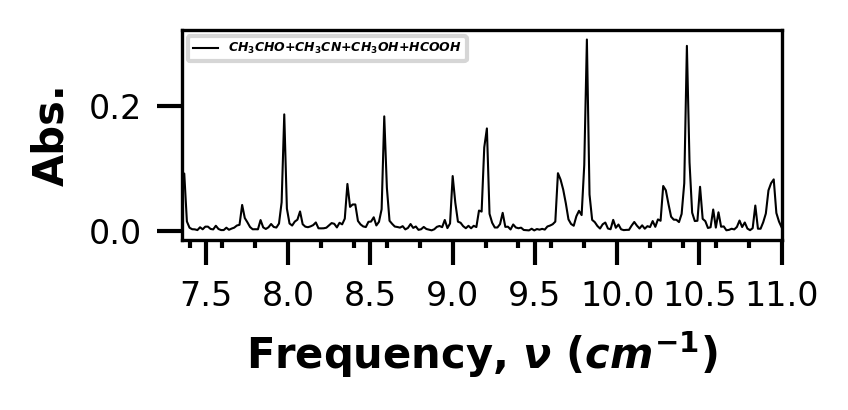

[0.0 0.10004007218160804 0.0 0.09893098577371864 0.17622286205415727 0.0
 0.24482363530868326 0.0]
['$C_2H_5OH$', '$CH_3CHO$', '$CH_3Cl$', '$CH_3CN$', '$CH_3OH$', '$H_2CO$', '$HCOOH$', '$HNO_3$']


In [40]:
idx = 239
simple_plotter(m.frequencies,X[idx],linewidth=0.5,color='black',label=mixture_names[idx], 
                   majorsize=6,minorsize=2,width=1, labelsize=8,legendsize=3, legendloc=2,  
                   labelpad=4,fontsize='medium',fontweight='bold',
                  xmajormplloc=0.5,xminormplloc=0.2, tickdirection='out')

print(y_concentrations[idx])
print(reduced_labels)

In [41]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(mixture_names)

mixture_types=le.classes_
print(mixture_types)

['$CH_3CHO$' '$CH_3CHO$+$CH_3CN$' '$CH_3CHO$+$CH_3CN$+$CH_3OH$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$HCOOH$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$HCOOH$+$HNO_3$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$HNO_3$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$H_2CO$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$H_2CO$+$HCOOH$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$H_2CO$+$HCOOH$+$HNO_3$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$H_2CO$+$HNO_3$'
 '$CH_3CHO$+$CH_3CN$+$HCOOH$' '$CH_3CHO$+$CH_3CN$+$HCOOH$+$HNO_3$'
 '$CH_3CHO$+$CH_3CN$+$HNO_3$' '$CH_3CHO$+$CH_3CN$+$H_2CO$'
 '$CH_3CHO$+$CH_3CN$+$H_2CO$+$HCOOH$'
 '$CH_3CHO$+$CH_3CN$+$H_2CO$+$HCOOH$+$HNO_3$'
 '$CH_3CHO$+$CH_3CN$+$H_2CO$+$HNO_3$' '$CH_3CHO$+$CH_3Cl$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$' '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$+$HCOOH$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$+$HCOOH$+$HNO_3$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$+$HNO_3$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$+$H_2CO$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$+$H_2CO$+$HCOOH$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN

In [42]:
#split intro train and validation set

#seeds used 123,237, 786
from sklearn.model_selection import train_test_split

global_indices=range(0, X.shape[0])
print(global_indices)

# (np.expand_dims(X,-1)
TRAIN_SIZE=0.60
VAL_SIZE=1-TRAIN_SIZE

x_train, x_val, y_train, y_val, train_indices, val_indices = train_test_split(np.expand_dims(X, axis=-1), y, global_indices, train_size=TRAIN_SIZE,
                                                   test_size=VAL_SIZE,
                                                   random_state=786,
                                                    stratify=y

                                                   )

print('X_train shape:', x_train.shape)
print('y_ohe_train shape:', y_train.shape)

print('X_val shape:', x_val.shape)
print('y_ohe_val shape:', y_val.shape)


print("All:", np.bincount(y) / float(len(y))*100  )
print("Training:", np.bincount(y_train) / float(len(y_train))*100  )
print("Validation:", np.bincount(y_val) / float(len(y_val))*100  )


range(0, 17850)
X_train shape: (10710, 229, 1)
y_ohe_train shape: (10710,)
X_val shape: (7140, 229, 1)
y_ohe_val shape: (7140,)
All: [0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686
 0.39215686 0.39215686 0.39215686 0.39215686 0.39215686 0.39215

In [43]:
y_val.shape

(7140,)

In [44]:
inputs = np.array([[1,0,1],
        [0,1,1],
        [0,0,1],
        [1,1,1]])
truths = np.array([[1, 1, 0, 0]]).T


print('inputs: ',inputs)
print('truths: ',truths)

print('inputs: ',inputs.shape)
print('truths: ',truths.shape)

inputs:  [[1 0 1]
 [0 1 1]
 [0 0 1]
 [1 1 1]]
truths:  [[1]
 [1]
 [0]
 [0]]
inputs:  (4, 3)
truths:  (4, 1)


In [45]:
y_ohe = concentrations_to_one_hot_encode(y_concentrations).astype('int64')
y_train_ohe = y_ohe[train_indices]
y_val_ohe = y_ohe[val_indices]
y_train_ohe_tensor = tf.convert_to_tensor(y_train_ohe, np.int64)
y_val_ohe_tensor = tf.convert_to_tensor(y_val_ohe, np.int64)

In [46]:
inputs=np.squeeze(x_train)
truths=y_train_ohe
# print('inputs: ',inputs)
# print('truths: ',truths)

print('inputs: ',inputs.shape)
print('truths: ',truths.shape)

inputs:  (10710, 229)
truths:  (10710, 8)


In [49]:
y_train_ohe[0]

array([0, 1, 0, 1, 1, 0, 0, 0])

In [63]:
data_x = torch.tensor(np.squeeze(x_train)).float()
data_y = torch.tensor(y_train_ohe).float()

torch.Size([10710, 229])
torch.Size([10710, 8])
Sequential(
  (0): Linear(in_features=229, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=8, bias=True)
  (3): Sigmoid()
)


Text(0, 0.5, 'loss')

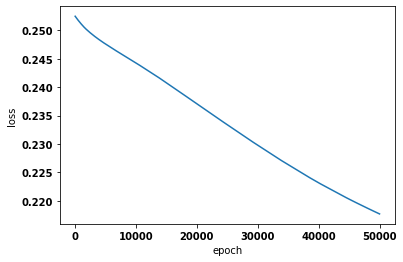

In [65]:

import torch
import torch.nn as nn

n_input, n_hidden, n_out, n_data, learning_rate = 229, 5, 8, 10710, 0.01

#n_input is the number of features in the input

#n_hidden is the number of of neurons in the hidden layer

#n_out is the number of features in the output layer

# data_x = torch.randn(n_data, n_input)
# data_y = (torch.rand(size = (n_data, 1)) < 0.5).float()
print(data_x.size())
print(data_y.size())

model = nn.Sequential(

    nn.Linear(n_input,n_hidden),
    nn.ReLU(),
    nn.Linear(n_hidden,n_out),
    nn.Sigmoid()
   
)

print(model)

loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

losses = []
for epoch in range(0, 50000):       
    pred_y = model(data_x)
    loss = loss_function(pred_y, data_y)
    losses.append(loss.item())

    model.zero_grad()
    loss.backward()

    optimizer.step()
    
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')

In [55]:
pred_y[0]

tensor([0.5381, 0.5918, 0.4643, 0.4986, 0.4234, 0.5655, 0.4202, 0.5741],
       grad_fn=<SelectBackward0>)

\begin{aligned}
        &\rule{110mm}{0.4pt}                                                                 \\
        &\textbf{input}      : \gamma \text{ (lr)}, \: \theta_0 \text{ (params)}, \: f(\theta)
            \text{ (objective)}, \: \lambda \text{ (weight decay)},                          \\
        &\hspace{13mm} \:\mu \text{ (momentum)}, \:\tau \text{ (dampening)},
        \:\textit{ nesterov,}\:\textit{ maximize}                                     \\[-1.ex]
        &\rule{110mm}{0.4pt}                                                                 \\
        &\textbf{for} \: t=1 \: \textbf{to} \: \ldots \: \textbf{do}                         \\
        &\hspace{5mm}g_t           \leftarrow   \nabla_{\theta} f_t (\theta_{t-1})           \\
        &\hspace{5mm}\textbf{if} \: \lambda \neq 0                                           \\
        &\hspace{10mm} g_t \leftarrow g_t + \lambda  \theta_{t-1}                            \\
        &\hspace{5mm}\textbf{if} \: \mu \neq 0                                               \\
        &\hspace{10mm}\textbf{if} \: t > 1                                                   \\
        &\hspace{15mm} \textbf{b}_t \leftarrow \mu \textbf{b}_{t-1} + (1-\tau) g_t           \\
        &\hspace{10mm}\textbf{else}                                                          \\
        &\hspace{15mm} \textbf{b}_t \leftarrow g_t                                           \\
        &\hspace{10mm}\textbf{if} \: \textit{nesterov}                                       \\
        &\hspace{15mm} g_t \leftarrow g_{t} + \mu \textbf{b}_t                             \\
        &\hspace{10mm}\textbf{else}                                                   \\[-1.ex]
        &\hspace{15mm} g_t  \leftarrow  \textbf{b}_t                                         \\
        &\hspace{5mm}\textbf{if} \: \textit{maximize}                                          \\
        &\hspace{10mm}\theta_t \leftarrow \theta_{t-1} + \gamma g_t                   \\[-1.ex]
        &\hspace{5mm}\textbf{else}                                                    \\[-1.ex]
        &\hspace{10mm}\theta_t \leftarrow \theta_{t-1} - \gamma g_t                   \\[-1.ex]
        &\rule{110mm}{0.4pt}                                                          \\[-1.ex]
        &\bf{return} \:  \theta_t                                                     \\[-1.ex]
        &\rule{110mm}{0.4pt}                                                          \\[-1.ex]
   \end{aligned}

Text(0, 0.5, 'loss')

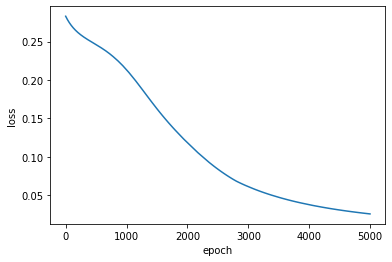

In [ ]:
model_name = data_filename.split('.pkl')[0].split('/')[1].replace('TSMCN', 'TSMMLCN')
print(model_name)

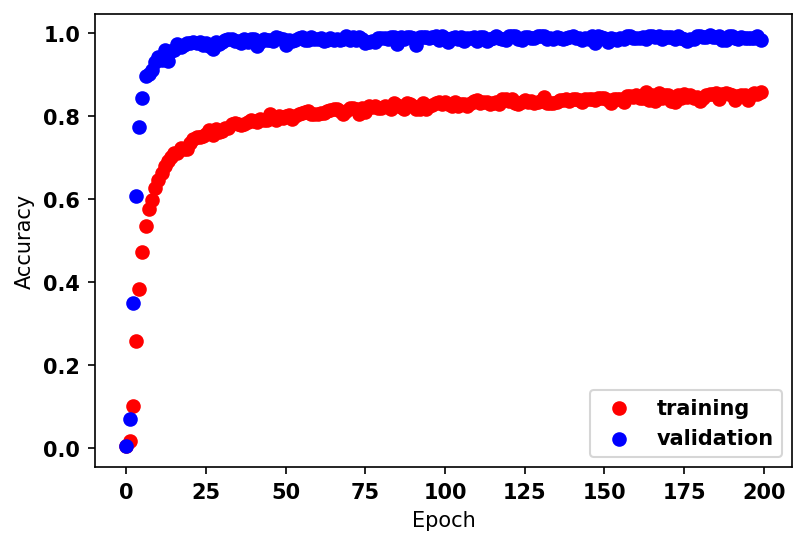

In [106]:
plt.figure(dpi=150)
plt.scatter(history.epoch,history.history['accuracy'], color = 'red', label = 'training')
plt.scatter(history.epoch,history.history['val_accuracy'], color = 'blue', label = 'validation')
plt.legend(loc=4)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig(r'RESULTS/results_figures/' + model_name + '_accuracies.png', bbox_inches='tight')

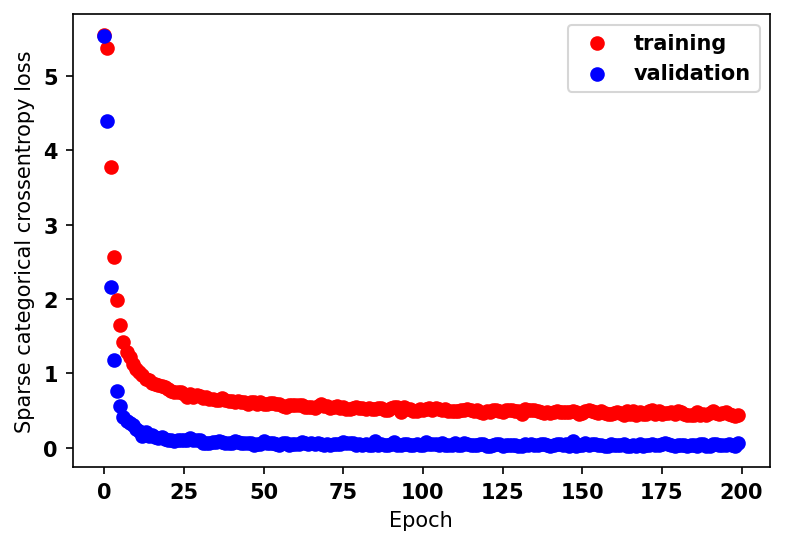

In [107]:
plt.figure(dpi=150)
plt.scatter(history.epoch,history.history['SparseCatCrossentropy'], color = 'red', label = 'training')
plt.scatter(history.epoch,history.history['val_SparseCatCrossentropy'],color = 'blue', label = 'validation')
plt.legend(loc=1)
plt.xlabel('Epoch')
plt.ylabel('Sparse categorical crossentropy loss')
plt.savefig(r'RESULTS/results_figures/'+ model_name + '_sparse_cat_losses.png', bbox_inches='tight')

In [108]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(x_val)


In [ ]:
#see distribution of counts of different types of mixtures.
# plt.barh(mixture_types,np.bincount(y))

plt.figure(figsize = (16,9),dpi=150)
plt.barh(mixture_types, np.bincount(y), color='teal')
plt.xlabel('Mixture components', fontweight = 'bold')
plt.ylabel('Counts', fontweight = 'bold')
plt.xticks(rotation=90);
plt.xticks(rotation=0);
plt.title('Distribution of mixture types in simulated noise-free spectra',  fontweight = 'bold')
plt.savefig(r'RESULTS/data_analytics/' + model_name +'_mix_type_dist.png', bbox_inches='tight')

# check if the functions below are also defined in oneida_utils

In [56]:
from oneida_utils import simple_spectrum_fig, simple_plot_raw_scores, plot_spectrum_with_scores, multiclass_roc_auc_score, multiclass_sensitivity_specificity_score, multiclass_sensitivity_threshold_score

In [ ]:
i=12
# simple_spectrum_fig(s.frequencies, x_val[i])
simple_plot_raw_scores(i, predictions, y_val,mixture_types)

In [ ]:
y_val.shape

In [109]:
pred_y=np.argmax(model.predict(x_val), axis=-1)

# adjust the accuracy score

In [110]:
from oneida_scoring_tools import calc_AMCAS, is_cui_present, is_cui_present_in_mult

In [111]:
y_val_named = mixture_types[y_val] # array consisting of string names of validation mixtures

y_train_named = mixture_types[y_train]

pred_y_named = mixture_types[pred_y] # array consisting of string names of predicted mixtures



In [112]:
AMCAS, correct_compounds_only  = calc_AMCAS(y_val_named,pred_y_named)

Adjusted Mixture Classification Accuracy Score (AMCAS):  99.69239362411639


In [113]:
correct_compounds_only

[['$CH_3CHO$', '$C_2H_5OH$', '$HCOOH$'],
 ['$CH_3CHO$', '$CH_3CN$', '$C_2H_5OH$', '$H_2CO$'],
 ['$CH_3Cl$', '$C_2H_5OH$', '$HCOOH$', '$HNO_3$'],
 ['$CH_3CHO$', '$CH_3OH$', '$C_2H_5OH$', '$H_2CO$'],
 ['$CH_3CHO$', '$CH_3CN$', '$CH_3OH$', '$C_2H_5OH$', '$HNO_3$', '$H_2CO$'],
 ['$CH_3CHO$', '$C_2H_5OH$', '$HNO_3$', '$H_2CO$'],
 ['$CH_3CHO$', '$CH_3CN$', '$CH_3Cl$', '$HCOOH$'],
 ['$CH_3CHO$', '$CH_3OH$', '$HCOOH$', '$HNO_3$', '$H_2CO$'],
 ['$CH_3CN$', '$CH_3OH$', '$C_2H_5OH$', '$HNO_3$'],
 ['$CH_3CHO$', '$CH_3CN$', '$CH_3Cl$', '$HNO_3$'],
 ['$CH_3CN$', '$HNO_3$', '$H_2CO$'],
 ['$CH_3CHO$', '$CH_3OH$', '$H_2CO$'],
 ['$CH_3CN$', '$CH_3Cl$', '$HCOOH$', '$HNO_3$'],
 ['$CH_3CHO$', '$CH_3Cl$', '$HNO_3$'],
 ['$CH_3CHO$', '$H_2CO$'],
 ['$CH_3CHO$', '$CH_3Cl$', '$CH_3OH$', '$HCOOH$'],
 ['$CH_3CHO$', '$C_2H_5OH$', '$HNO_3$'],
 ['$CH_3CHO$', '$CH_3CN$', '$CH_3OH$', '$HCOOH$', '$HNO_3$', '$H_2CO$'],
 ['$CH_3CN$', '$CH_3Cl$', '$HNO_3$', '$H_2CO$'],
 ['$CH_3CN$', '$CH_3Cl$', '$C_2H_5OH$'],
 ['$CH_3CHO$'

In [114]:
# check if a particular compound is detected in the predictions

# cui = compound under investigation

cui = '$HNO_3$'

is_cui_present(cui, y_val_named, correct_compounds_only,verbosity = False )    

99.94419642857143

In [ ]:
is_cui_present(cui, y_val_named, correct_compounds_only,verbosity = True )    

In [ ]:
#calculate the distribution of 1,2,3,4,5 mixtures in train spectra

mix_1c = 0
mix_2c = 0
mix_3c = 0
mix_4c = 0
mix_5c = 0
mix_6c = 0
mix_7c = 0
mix_8c = 0

for _ in range(0,y_train_named.shape[0]):
    
        if len(y_train_named[_].split('+', -1)) == 1:
            mix_1c+=1
        elif len(y_train_named[_].split('+', -1)) == 2:
            mix_2c+=1
        elif len(y_train_named[_].split('+', -1)) == 3:
            mix_3c+=1
        elif len(y_train_named[_].split('+', -1)) == 4:
            mix_4c+=1
        elif len(y_train_named[_].split('+', -1)) == 5:
            mix_5c+=1
        elif len(y_train_named[_].split('+', -1)) == 6:
            mix_6c+=1       
        elif len(y_train_named[_].split('+', -1)) == 7:
            mix_7c+=1   
        elif len(y_train_named[_].split('+', -1)) == 8:
            mix_8c+=1
           
            
print('1-component mixtures:', mix_1c)
print('2-component mixtures:', mix_2c)
print('3-component mixtures:', mix_3c)
print('4-component mixtures:', mix_4c)
print('5-component mixtures:', mix_5c)
print('6-component mixtures:', mix_6c)
print('7-component mixtures:', mix_7c)
print('8-component mixtures:', mix_8c)

plt.figure(figsize=(16,10),dpi=150)
mix_dist_labels = ['1-component\n8\n classes','2-components\n28\n classes','3-components\n56\n classes','4-components\n70\n classes','5-components\n56\n classes','6-components\n28\n classes','7-components\n8\n classes','8-components\n1\n class']
mix_dists = [mix_1c,mix_2c,mix_3c,mix_4c,mix_5c,mix_6c,mix_7c,mix_8c]
plt.bar(mix_dist_labels, mix_dists, color='darkblue')
plt.xlabel('Mixture components', fontsize=1, fontweight = 'bold')
plt.ylabel('Counts', fontweight = 'bold')
plt.title('Distribution of mixture components in train spectra',  fontweight = 'bold')
plt.savefig(r'RESULTS/data_analytics/' + model_name +'_train_mix_dist.png', bbox_inches='tight')

In [ ]:
np.sum(mix_dists)

In [ ]:
#calculate the distribution of 1,2,3,4,5 mixtures in validation spectra


mix_1c = 0
mix_2c = 0
mix_3c = 0
mix_4c = 0
mix_5c = 0
mix_6c = 0
mix_7c = 0
mix_8c = 0

for _ in range(0,y_val_named.shape[0]):
    
        if len(y_val_named[_].split('+', -1)) == 1:
            mix_1c+=1
        elif len(y_val_named[_].split('+', -1)) == 2:
            mix_2c+=1
        elif len(y_val_named[_].split('+', -1)) == 3:
            mix_3c+=1
        elif len(y_val_named[_].split('+', -1)) == 4:
            mix_4c+=1
        elif len(y_val_named[_].split('+', -1)) == 5:
            mix_5c+=1
        elif len(y_val_named[_].split('+', -1)) == 6:
            mix_6c+=1       
        elif len(y_val_named[_].split('+', -1)) == 7:
            mix_7c+=1   
        elif len(y_val_named[_].split('+', -1)) == 8:
            mix_8c+=1
           
            
6

            
print('1-component mixtures:', mix_1c)
print('2-component mixtures:', mix_2c)
print('3-component mixtures:', mix_3c)
print('4-component mixtures:', mix_4c)
print('5-component mixtures:', mix_5c)
print('6-component mixtures:', mix_6c)
print('7-component mixtures:', mix_7c)
print('8-component mixtures:', mix_8c)

plt.figure(figsize=(16,10),dpi=150)

mix_dist_labels = ['1-component\n8\n classes','2-components\n28\n classes','3-components\n56\n classes','4-components\n70\n classes','5-components\n56\n classes','6-components\n28\n classes','7-components\n8\n classes','8-components\n1\n class']
mix_dists = [mix_1c,mix_2c,mix_3c,mix_4c,mix_5c,mix_6c,mix_7c,mix_8c]
plt.bar(mix_dist_labels, mix_dists, color='orange')
plt.xlabel('Mixture components',fontsize=1, fontweight = 'bold')
plt.ylabel('Counts', fontweight = 'bold')
plt.title('Distribution of mixture components in validation spectra',  fontweight = 'bold')
plt.savefig(r'RESULTS/data_analytics/' + model_name +'_val_mix_dist.png', bbox_inches='tight')

In [ ]:
np.sum(mix_dists)

In [ ]:
ncr(5, 5)

In [ ]:
# broad_pcnt_det_cui= [] #broad detection percent of cuis
# for cui in m.labels:
#     broad_pcnt_det_cui.append(is_cui_present(cui, y_val_named,correct_compounds_only, verbosity=False))
# #     print(cui)
# #     print(is_cui_present(cui, y_test_named,verbosity=False))

In [ ]:
# broad_pcnt_det_cui= [] #broad detection percent of cuis
# for cui in m.labels:
#     broad_pcnt_det_cui.append(is_cui_present(cui, y_val_named,correct_compounds_only, verbosity=False))
# #     print(cui)
# #     print(is_cui_present(cui, y_test_named,verbosity=False))

# plt.figure(figsize = (16,10), dpi=150)
# plt.bar(m.labels,broad_pcnt_det_cui)
# plt.xlabel('Molecule')
# plt.ylabel('AMCAS')
# plt.savefig(r'RESULTS/results_figures/' + model_name +'_cui_det_broad.png', bbox_inches='tight')

In [ ]:
is_cui_present_in_mult(cui, y_val_named, correct_compounds_only, n_mixture_component = 1, verbosity=True)

In [ ]:
y_val_named.shape[0]

In [ ]:
m.labels

In [ ]:
results = np.zeros((5,6))

In [ ]:
def get_detailed_results(y_val_named,correct_compounds_only):
    
    results = np.zeros((5,6))
    results[0,0]=is_cui_present_in_mult('$CH_3CHO$', y_val_named, correct_compounds_only, n_mixture_component = 1, verbosity=False)[0]
    results[0,1]=is_cui_present_in_mult('$CH_3CHO$', y_val_named, correct_compounds_only, n_mixture_component = 2, verbosity=False)[0]
    results[0,2]=is_cui_present_in_mult('$CH_3CHO$', y_val_named, correct_compounds_only, n_mixture_component = 3, verbosity=False)[0]
    results[0,3]=is_cui_present_in_mult('$CH_3CHO$', y_val_named, correct_compounds_only, n_mixture_component = 4, verbosity=False)[0]
    results[0,4]=is_cui_present_in_mult('$CH_3CHO$', y_val_named, correct_compounds_only, n_mixture_component = 5, verbosity=False)[0]
    results[0,5] = results[0,0]+ results[0,1] + results[0,2] + results[0,3] + results[0,4]

    results[1,0]=is_cui_present_in_mult('$CH_3Cl$', y_val_named, correct_compounds_only, n_mixture_component = 1, verbosity=False)[0]
    results[1,1]=is_cui_present_in_mult('$CH_3Cl$', y_val_named, correct_compounds_only, n_mixture_component = 2, verbosity=False)[0]
    results[1,2]=is_cui_present_in_mult('$CH_3Cl$', y_val_named, correct_compounds_only, n_mixture_component = 3, verbosity=False)[0]
    results[1,3]=is_cui_present_in_mult('$CH_3Cl$', y_val_named, correct_compounds_only, n_mixture_component = 4, verbosity=False)[0]
    results[1,4]=is_cui_present_in_mult('$CH_3Cl$', y_val_named, correct_compounds_only, n_mixture_component = 5, verbosity=False)[0]
    results[1,5] = results[1,0]+ results[1,1] + results[1,2] + results[1,3] + results[1,4]

    results[2,0]=is_cui_present_in_mult('$CH_3CN$', y_val_named, correct_compounds_only, n_mixture_component = 1, verbosity=False)[0]
    results[2,1]=is_cui_present_in_mult('$CH_3CN$', y_val_named, correct_compounds_only, n_mixture_component = 2, verbosity=False)[0]
    results[2,2]=is_cui_present_in_mult('$CH_3CN$', y_val_named, correct_compounds_only, n_mixture_component = 3, verbosity=False)[0]
    results[2,3]=is_cui_present_in_mult('$CH_3CN$', y_val_named, correct_compounds_only, n_mixture_component = 4, verbosity=False)[0]
    results[2,4]=is_cui_present_in_mult('$CH_3CN$', y_val_named, correct_compounds_only, n_mixture_component = 5, verbosity=False)[0]
    results[2,5] = results[2,0]+ results[2,1] + results[2,2] + results[2,3] + results[2,4]

    results[3,0]=is_cui_present_in_mult('$CH_3OH$', y_val_named, correct_compounds_only, n_mixture_component = 1, verbosity=False)[0]
    results[3,1]=is_cui_present_in_mult('$CH_3OH$', y_val_named, correct_compounds_only, n_mixture_component = 2, verbosity=False)[0]
    results[3,2]=is_cui_present_in_mult('$CH_3OH$', y_val_named, correct_compounds_only, n_mixture_component = 3, verbosity=False)[0]
    results[3,3]=is_cui_present_in_mult('$CH_3OH$', y_val_named, correct_compounds_only, n_mixture_component = 4, verbosity=False)[0]
    results[3,4]=is_cui_present_in_mult('$CH_3OH$', y_val_named, correct_compounds_only,n_mixture_component = 5, verbosity=False)[0]
    results[3,5] = results[3,0]+ results[3,1] + results[3,2] + results[3,3] + results[3,4]

    results[4,0]=is_cui_present_in_mult('$HNO_3$', y_val_named, correct_compounds_only, n_mixture_component = 1, verbosity=False)[0]
    results[4,1]=is_cui_present_in_mult('$HNO_3$', y_val_named, correct_compounds_only, n_mixture_component = 2, verbosity=False)[0]
    results[4,2]=is_cui_present_in_mult('$HNO_3$', y_val_named, correct_compounds_only, n_mixture_component = 3, verbosity=False)[0]
    results[4,3]=is_cui_present_in_mult('$HNO_3$', y_val_named, correct_compounds_only, n_mixture_component = 4, verbosity=False)[0]
    results[4,4]=is_cui_present_in_mult('$HNO_3$', y_val_named, correct_compounds_only, n_mixture_component = 5, verbosity=False)[0]
    results[4,5] = results[4,0]+ results[4,1] + results[4,2] + results[4,3] + results[4,4]
    
    return results

In [ ]:
results = get_detailed_results(y_val_named,correct_compounds_only)

In [ ]:
results

In [ ]:

results_df = pd.DataFrame()
results_df['1-comp'] = results[:,0]
results_df['2-comp'] = results[:,1]
results_df['3-comp'] = results[:,2]
results_df['4-comp'] = results[:,3]
results_df['5-comp'] = results[:,4]
results_df['Total'] = results[:,5]

In [ ]:
print(results_df.rename(index={0: m.labels[0], 1: m.labels[1], 2: m.labels[2],3: m.labels[3],4: m.labels[4]}).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  1-comp &     2-comp &     3-comp &     4-comp &    5-comp &      Total \\
\midrule
\$CH\_3CHO\$ &    6.25 &  24.492188 &  35.726562 &  23.078125 &  5.359375 &  94.906250 \\
\$CH\_3Cl\$  &    6.25 &  24.671875 &  36.187500 &  23.953125 &  5.875000 &  96.937500 \\
\$CH\_3CN\$  &    6.25 &  24.765625 &  36.898438 &  24.523438 &  6.054688 &  98.492188 \\
\$CH\_3OH\$  &    6.25 &  23.835938 &  34.648438 &  22.617188 &  5.671875 &  93.023438 \\
\$HNO\_3\$   &    6.25 &  24.515625 &  36.250000 &  23.523438 &  5.664062 &  96.203125 \\
\bottomrule
\end{tabular}

In [ ]:
# find percentages of each component of mixtures

counts = 0
for _ in range(0,y_val_named.shape[0]):

        if len(y_val_named[_].split('+', -1)) == 5:
            counts+=1
            
            
print(counts)

In [ ]:
cm = confusion_matrix(y_val, pred_y)
plt.rc('font', weight='bold')

fig = plt.figure(figsize=(16,10), dpi = 300);
# plt.title('Confusion matrix);

# ax = sns.heatmap(cm, annot=True, cmap='PiYG');   #cmap='coolwarm' also good
ax = sns.heatmap(cm, annot=True, fmt='', cmap = 'Blues', annot_kws={"size": 12}, cbar=True);   #cmap='coolwarm' also good
#ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues') #Shows percentage

# comprehend the array to get labels which can be made bold
# ax.set_xticklabels([x.replace('$','').replace('_','') for x in mixture_types]);
# ax.set_yticklabels([x.replace('$','').replace('_','') for x in mixture_types]);

# turn the following on to get correct notation of chemical formulas but in math form
# ax.set_yticklabels(mixture_types)
# ax.set_yticklabels(mixture_types)

# plt.xlabel('Predicted Mixture',fontsize='medium', fontweight='bold');
# plt.ylabel('Actual Mixture',fontsize='medium', fontweight='bold');
# plt.xticks(rotation=90,fontsize='medium', fontweight='bold');
# plt.yticks(rotation=0,fontsize='medium', fontweight='bold');
plt.savefig(r'RESULTS/results_figures/' + model_name + '_cm_val_data.png', bbox_inches='tight')

In [115]:
from aimos.misc.utils import classifier_internals
from aimos.misc.utils import clf_post_processor


In [116]:
classifier_internals(pred_y, y_val, y_train, 'test-voc-net-style')

---------------------------- test-voc-net-style -------------------------------
Fraction Correct[Accuracy]:
0.9851540616246499
Samples Correctly Classified:
(array([   0,    1,    2, ..., 7137, 7138, 7139]),)
Samples Incorrectly Classified:
(array([  30,  120,  248,  262,  385,  443,  560,  594,  719,  787,  823,
        959,  977,  983, 1197, 1204, 1261, 1343, 1379, 1386, 1474, 1477,
       1507, 1594, 1627, 1723, 1738, 1839, 1954, 2059, 2133, 2174, 2200,
       2291, 2317, 2331, 2536, 2582, 2779, 2825, 2850, 2855, 3072, 3089,
       3141, 3161, 3216, 3244, 3544, 3568, 3576, 3656, 3712, 3738, 3788,
       3858, 3913, 3919, 4008, 4226, 4393, 4423, 4432, 4488, 4646, 4677,
       4757, 4807, 4948, 5016, 5090, 5165, 5174, 5193, 5273, 5321, 5335,
       5357, 5516, 5636, 5684, 5797, 5993, 6016, 6052, 6069, 6093, 6181,
       6186, 6257, 6384, 6398, 6407, 6418, 6450, 6457, 6545, 6569, 6583,
       6629, 6663, 6684, 6844, 6881, 6942, 6971]),)
All Train y with label identifier [  2  63  51 ..

In [ ]:
fig = plot_spectrum_with_scores(np.squeeze(x_val), y_val, predictions, m.frequencies,mixture_types, 19, dpi = 300)

# fig.savefig(r'RESULTS/results_figures/' + model_name + 'softmax_figures_test_spectra_start_idx_201.png', bbox_inches='tight')

In [ ]:
# print('ROC AUC score:', multiclass_roc_auc_score(y_val, pred_y, mixture_types)[0])

# fig = multiclass_roc_auc_score(y_val, pred_y, mixture_types)[1]
# # fig.savefig(r'RESULTS/results_figures/' + model_name + 'ROC_test_data.png', bbox_inches='tight')
# fig

In [ ]:
# one hot code labels

In [118]:
y_val_ohe = concentrations_to_one_hot_encode(y_concentrations[val_indices]).astype('int64')

In [119]:
y_val_ohe

array([[1, 1, 0, ..., 0, 1, 0],
       [1, 1, 0, ..., 1, 0, 0],
       [1, 0, 1, ..., 0, 1, 1],
       ...,
       [1, 0, 1, ..., 1, 0, 0],
       [1, 1, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 1, 1, 0]])

In [120]:
pred_y[0]

178

In [121]:
mixture_types[1]

'$CH_3CHO$+$CH_3CN$'

In [122]:
mixture_names[3]

'$CH_3CHO$'

In [123]:
print(mixture_types)

['$CH_3CHO$' '$CH_3CHO$+$CH_3CN$' '$CH_3CHO$+$CH_3CN$+$CH_3OH$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$HCOOH$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$HCOOH$+$HNO_3$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$HNO_3$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$H_2CO$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$H_2CO$+$HCOOH$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$H_2CO$+$HCOOH$+$HNO_3$'
 '$CH_3CHO$+$CH_3CN$+$CH_3OH$+$H_2CO$+$HNO_3$'
 '$CH_3CHO$+$CH_3CN$+$HCOOH$' '$CH_3CHO$+$CH_3CN$+$HCOOH$+$HNO_3$'
 '$CH_3CHO$+$CH_3CN$+$HNO_3$' '$CH_3CHO$+$CH_3CN$+$H_2CO$'
 '$CH_3CHO$+$CH_3CN$+$H_2CO$+$HCOOH$'
 '$CH_3CHO$+$CH_3CN$+$H_2CO$+$HCOOH$+$HNO_3$'
 '$CH_3CHO$+$CH_3CN$+$H_2CO$+$HNO_3$' '$CH_3CHO$+$CH_3Cl$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$' '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$+$HCOOH$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$+$HCOOH$+$HNO_3$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$+$HNO_3$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$+$H_2CO$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN$+$CH_3OH$+$H_2CO$+$HCOOH$'
 '$CH_3CHO$+$CH_3Cl$+$CH_3CN

In [124]:
from oneida_utils import mixture_names_to_one_hot_encode

In [125]:
pred_y_ohe = mixture_names_to_one_hot_encode(pred_y_named, reduced_labels, verbosity = False)

In [72]:
# for _ in range(0, pred_y_named.shape[0]):
    
    
#     if pred_y_named[_] != y_val_named[_]:
#         print(_)
    
    
# #     print('pred:',  pred_y_named[_])
# #     print('actual:', y_val_named[_])

In [126]:
print('pred:',  pred_y_named[11])
print('actual:', y_val_named[11])

pred: $CH_3CHO$+$CH_3OH$+$H_2CO$
actual: $CH_3CHO$+$CH_3OH$+$H_2CO$


In [42]:
beta_testing_df = pd.DataFrame()
beta_testing_df['pred'] = pred_y_named
beta_testing_df['actual'] = y_val_named

beta_testing_df['pred_y_integer'] = pred_y
beta_testing_df['y_val_integer'] = y_val

beta_testing_df['pred_y_ohe0'] = pred_y_ohe[:,0]
beta_testing_df['pred_y_ohe1'] = pred_y_ohe[:,1]
beta_testing_df['pred_y_ohe2'] = pred_y_ohe[:,2]
beta_testing_df['pred_y_ohe3'] = pred_y_ohe[:,3]
beta_testing_df['pred_y_ohe4'] = pred_y_ohe[:,4]
beta_testing_df['pred_y_ohe5'] = pred_y_ohe[:,5]
beta_testing_df['pred_y_ohe6'] = pred_y_ohe[:,6]
beta_testing_df['pred_y_ohe7'] = pred_y_ohe[:,7]
beta_testing_df['y_val_ohe0'] = y_val_ohe[:,0]
beta_testing_df['y_val_ohe1'] = y_val_ohe[:,1]
beta_testing_df['y_val_ohe2'] = y_val_ohe[:,2]
beta_testing_df['y_val_ohe3'] = y_val_ohe[:,3]
beta_testing_df['y_val_ohe4'] = y_val_ohe[:,4]
beta_testing_df['y_val_ohe5'] = y_val_ohe[:,5]
beta_testing_df['y_val_ohe6'] = y_val_ohe[:,6]
beta_testing_df['y_val_ohe7'] = y_val_ohe[:,7]

In [43]:
beta_testing_df.to_csv('beta_testing.csv')

In [ ]:

# pred_y_ohe = []
# for named_value in pred_y_named:
#     species_list =  named_value.split('+')
#     n_species = len(species_list)
#     print("n_species: ", n_species)
#     print(species_list)
#     output_hot_encode = [0,0,0,0,0]
#     for _ in range(0, n_species):
#         print(species_list[_])
#         sp_index = reduced_labels.index(species_list[_])
#         print(sp_index)
#         output_hot_encode[sp_index] = 1


#     print(output_hot_encode)  
#     pred_y_ohe.append(output_hot_encode)

In [127]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_val_ohe, pred_y_ohe)

array([[[3556,    0],
        [  10, 3574]],

       [[3556,    0],
        [   7, 3577]],

       [[3556,    0],
        [  21, 3563]],

       [[3556,    0],
        [   2, 3582]],

       [[3556,    0],
        [  16, 3568]],

       [[3555,    1],
        [  11, 3573]],

       [[3556,    0],
        [  38, 3546]],

       [[3556,    0],
        [   2, 3582]]])

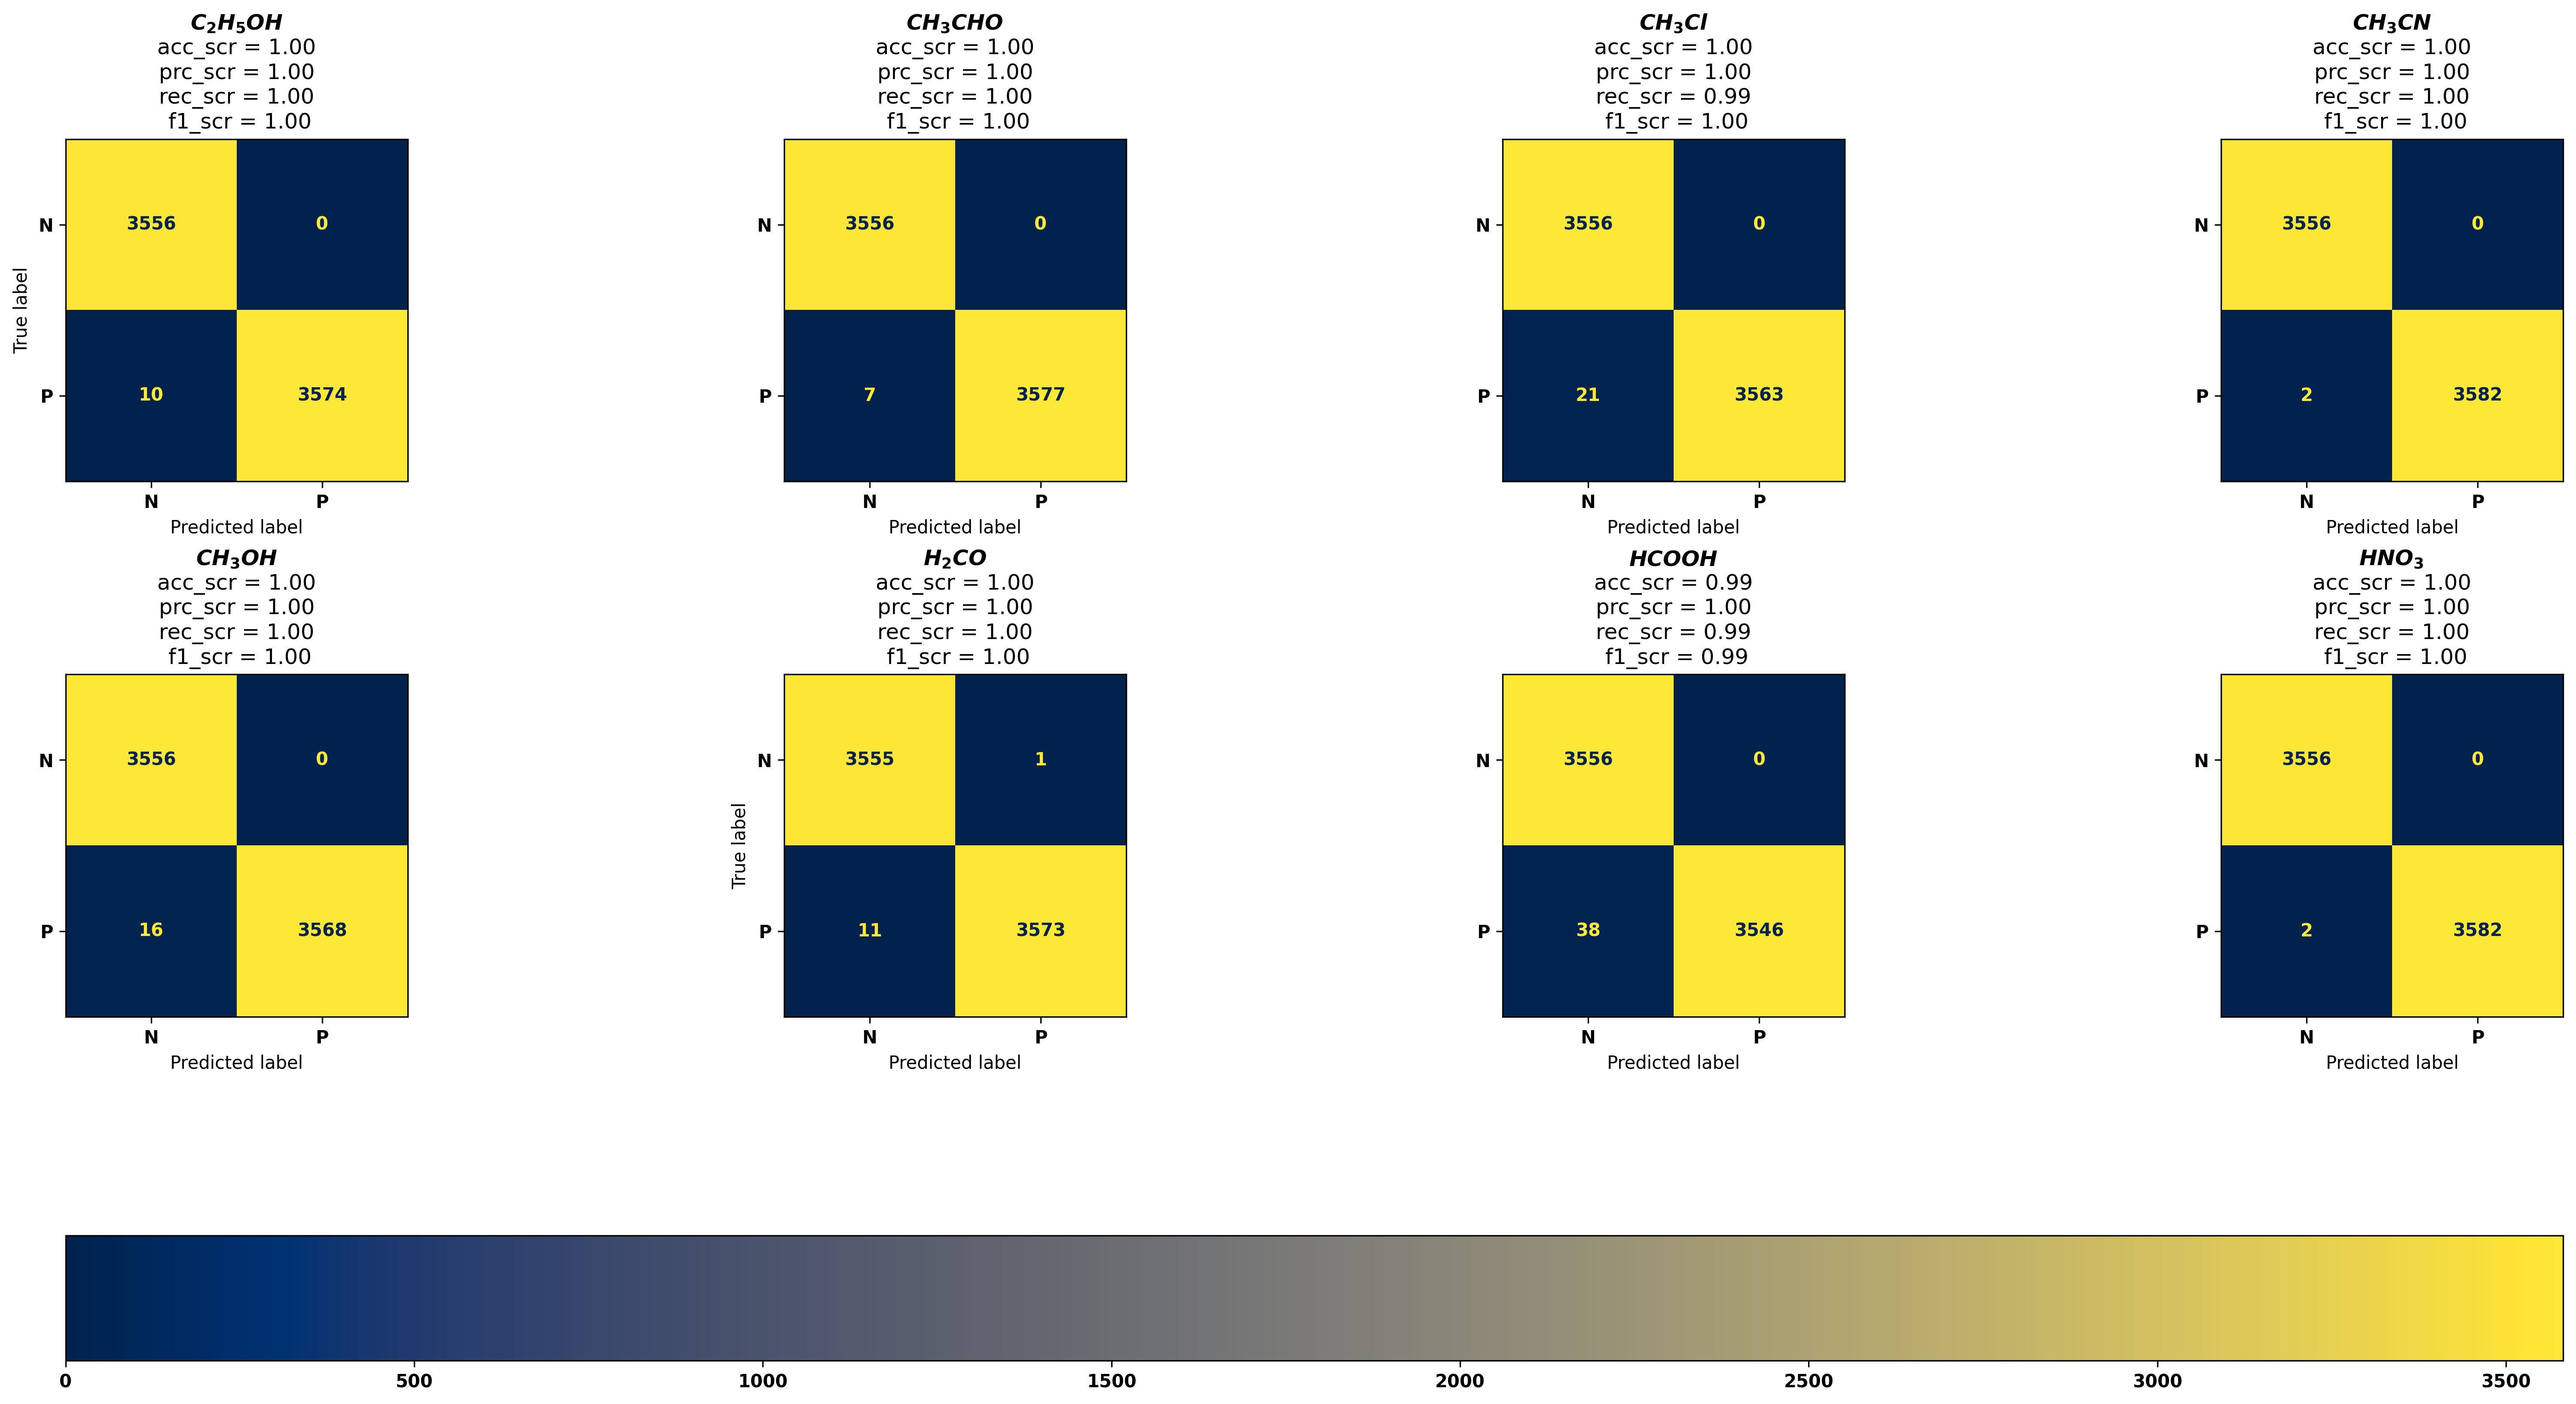

In [128]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


f, axes = plt.subplots(2, 4, figsize=(25, 15), dpi=300)

axes = axes.ravel()
for i in range(8):
    acc_scr = accuracy_score(y_val_ohe[:, i], pred_y_ohe[:, i])
    prc_scr = precision_score(y_val_ohe[:, i], pred_y_ohe[:, i])
    rec_scr = recall_score(y_val_ohe[:, i], pred_y_ohe[:, i])
    f1_scr = f1_score(y_val_ohe[:, i], pred_y_ohe[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix(y_val_ohe[:, i],
                                                   pred_y_ohe[:, i]),
                                  display_labels=['N', 'P'])

#     disp = ConfusionMatrixDisplay.from_predictions(y_val_ohe[:, i],
#                                                    y_pred_ohe[:, i], cmap = 'Blues',
#                                   display_labels=['N', 'P'])
    
    disp.plot(ax=axes[i], cmap='cividis',)
#     disp.plot(ax=axes[i], values_format='.4g'
    disp.ax_.set_title(f'{reduced_labels[i]} \n acc_scr = {acc_scr:.2f} \n prc_scr = {prc_scr:.2f} \n rec_scr = {rec_scr:.2f} \n f1_scr = {f1_scr:.2f}')
    if i<10:
        disp.ax_.set_xlabel('Predicted label')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()
    
plt.subplots_adjust(wspace=1.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes, orientation = 'horizontal')
plt.show()
f.savefig(r'RESULTS/results_figures/' + model_name + '_cm_bin_val.png', bbox_inches='tight')

# Grad-cam needs more work

In [ ]:
from oneida_grad_cam import grad_cam

In [ ]:
left=0.1,
                    bottom=0.,
                    right=0.9,
                    top=0.9,left=0.1,
                    bottom=0.,
                    right=0.9,
                    top=0.9,layer_name = 'C7'
#calculate max heatmap value to normalize the plots
max_heat_map_vals=[]
min_heat_map_vals=[]
for i in x_val:
    
    data = np.expand_dims(i,0)
    heatmap = grad_cam(layer_name,data, model)
    max_heat_map_vals.append(np.max(heatmap))
    min_heat_map_vals.append(np.min(heatmap))

print(f'layer {layer_name} class activation maps')

font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }

freq_GHz = 29.9792458*m.frequencies

count = 0





for i,j,k in zip(x_val,y_val,pred_y):
    
    data = np.expand_dims(i,0)
    heatmap = grad_cam(layer_name,data, model)
    
#     norm_heat_map = (heatmap-min(min_heat_map_vals))/(max(max_heat_map_vals)-min(min_heat_map_vals)) #normalize globally
    
# #     norm_heat_map = (heatmap-np.min(heatmap))//(np.max(heatmap)-np.min(heatmap)) # normalzie individual heatmaps
    
#     #normalized map
#     fig = plt.figure(figsize=(30,4),dpi=300)
#     plt.imshow(np.expand_dims(norm_heat_map,axis=2), aspect="auto", cmap='inferno_r', interpolation='nearest',extent=[0,229,i.min(),i.max()], alpha=0.8)
    
#     ticklist = range(0,229)
# #     plt.xticks(ticklist[::30], np.round(m.frequencies.tolist()[::30], decimals=1) ) # tick every 40th frequency
#     plt.xticks(ticklist[::20], np.round(freq_GHz[::20], decimals=1) ) # tick every 40th frequency
#     plt.plot(i,'k',linewidth=3)
    
#     if mixture_types[j] != mixture_types[k]:
#         plt.title(f'actual:{mixture_types[j]}, predicted:{mixture_types[k]}', color='red', fontdict=font)
#     else:
#         plt.title(f'actual:{mixture_types[j]}, predicted:{mixture_types[k]}', color='black', fontdict=font)
#     plt.colorbar()
# #     plt.clim(np.min(norm_heat_map),np.max(norm_heat_map))
#     plt.clim(0,1)
#     print(np.min(norm_heat_map))
#     print(np.max(norm_heat_map))
#     plt.show()
    
    
    # raw map
    fig = plt.figure(figsize=(30,4),dpi=300)
    plt.imshow(np.expand_dims(heatmap,axis=2),cmap='YlGnBu', aspect="auto", interpolation='nearest',extent=[0,229,i.min(),i.max()], alpha=0.8)
    
    ticklist = range(0,229)
#     plt.xticks(ticklist[::30], np.round(m.frequencies.tolist()[::30], decimals=1) ) # tick every 40th frequency
    plt.xticks(ticklist[::20], np.round(freq_GHz[::20], decimals=1) ) # tick every 40th frequency
    plt.plot(i,'k',linewidth=3)
    
    if mixture_types[j] != mixture_types[k]:
        plt.title(f'actual:{mixture_types[j]}, predicted:{mixture_types[k]}', color='red', fontdict=font)
    else:
        plt.title(f'actual:{mixture_types[j]}, predicted:{mixture_types[k]}', color='black', fontdict=font)
    plt.colorbar()
    plt.clim(np.min(heatmap),np.max(heatmap))
    plt.show()
    
    
    fig.savefig(r'RESULTS/grad_cam_multi_class/CAM_C7_val' + str(count) + '.png', bbox_inches='tight')
    count = count + 1
    
    if count ==2:
        break
        
        

In [ ]:
layer_name = 'C5'
#calculate max heatmap value to normalize the plots
max_heat_map_vals=[]
min_heat_map_vals=[]
for i in x_val:
    
    data = np.expand_dims(i,0)
    heatmap = grad_cam(layer_name,data, model)
    max_heat_map_vals.append(np.max(heatmap))
    min_heat_map_vals.append(np.min(heatmap))

print(f'layer {layer_name} class activation maps')

font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }

freq_GHz = 29.9792458*m.frequencies

count = 0





for i,j,k in zip(x_val,y_val,pred_y):
    
    data = np.expand_dims(i,0)
    heatmap = grad_cam(layer_name,data, model)
    
#     norm_heat_map = (heatmap-min(min_heat_map_vals))/(max(max_heat_map_vals)-min(min_heat_map_vals)) #normalize globally
    
# #     norm_heat_map = (heatmap-np.min(heatmap))//(np.max(heatmap)-np.min(heatmap)) # normalzie individual heatmaps
    
#     #normalized map
#     fig = plt.figure(figsize=(30,4),dpi=300)
#     plt.imshow(np.expand_dims(norm_heat_map,axis=2), aspect="auto", cmap='inferno_r', interpolation='nearest',extent=[0,229,i.min(),i.max()], alpha=0.8)
    
#     ticklist = range(0,229)
# #     plt.xticks(ticklist[::30], np.round(m.frequencies.tolist()[::30], decimals=1) ) # tick every 40th frequency
#     plt.xticks(ticklist[::20], np.round(freq_GHz[::20], decimals=1) ) # tick every 40th frequency
#     plt.plot(i,'k',linewidth=3)
    
#     if mixture_types[j] != mixture_types[k]:
#         plt.title(f'actual:{mixture_types[j]}, predicted:{mixture_types[k]}', color='red', fontdict=font)
#     else:
#         plt.title(f'actual:{mixture_types[j]}, predicted:{mixture_types[k]}', color='black', fontdict=font)
#     plt.colorbar()
# #     plt.clim(np.min(norm_heat_map),np.max(norm_heat_map))
#     plt.clim(0,1)
#     print(np.min(norm_heat_map))
#     print(np.max(norm_heat_map))
#     plt.show()
    
    
    # raw map
    fig = plt.figure(figsize=(30,4),dpi=300)
    plt.imshow(np.expand_dims(heatmap,axis=2),cmap='YlGnBu', aspect="auto", interpolation='nearest',extent=[0,229,i.min(),i.max()], alpha=0.8)
    
    ticklist = range(0,229)
#     plt.xticks(ticklist[::30], np.round(m.frequencies.tolist()[::30], decimals=1) ) # tick every 40th frequency
    plt.xticks(ticklist[::20], np.round(freq_GHz[::20], decimals=1) ) # tick every 40th frequency
    plt.plot(i,'k',linewidth=3)
    
    if mixture_types[j] != mixture_types[k]:
        plt.title(f'actual:{mixture_types[j]}, predicted:{mixture_types[k]}', color='red', fontdict=font)
    else:
        plt.title(f'actual:{mixture_types[j]}, predicted:{mixture_types[k]}', color='black', fontdict=font)
    plt.colorbar()
    plt.clim(np.min(heatmap),np.max(heatmap))
    plt.show()
    
    
    fig.savefig(r'RESULTS/grad_cam_multi_class/CAM_C5_val' + str(count) + '.png', bbox_inches='tight')
    count = count + 1
    
    if count ==2:
        break
        
        

In [ ]:
layer_name = 'C3'
#calculate max heatmap value to normalize the plots
max_heat_map_vals=[]
min_heat_map_vals=[]
for i in x_val:
    
    data = np.expand_dims(i,0)
    heatmap = grad_cam(layer_name,data, model)
    max_heat_map_vals.append(np.max(heatmap))
    min_heat_map_vals.append(np.min(heatmap))

print(f'layer {layer_name} class activation maps')

font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }

freq_GHz = 29.9792458*m.frequencies

count = 0





for i,j,k in zip(x_val,y_val,pred_y):
    
    data = np.expand_dims(i,0)
    heatmap = grad_cam(layer_name,data, model)
    
#     norm_heat_map = (heatmap-min(min_heat_map_vals))/(max(max_heat_map_vals)-min(min_heat_map_vals)) #normalize globally
    
# #     norm_heat_map = (heatmap-np.min(heatmap))//(np.max(heatmap)-np.min(heatmap)) # normalzie individual heatmaps
    
#     #normalized map
#     fig = plt.figure(figsize=(30,4),dpi=300)
#     plt.imshow(np.expand_dims(norm_heat_map,axis=2), aspect="auto", cmap='inferno_r', interpolation='nearest',extent=[0,229,i.min(),i.max()], alpha=0.8)
    
#     ticklist = range(0,229)
# #     plt.xticks(ticklist[::30], np.round(m.frequencies.tolist()[::30], decimals=1) ) # tick every 40th frequency
#     plt.xticks(ticklist[::20], np.round(freq_GHz[::20], decimals=1) ) # tick every 40th frequency
#     plt.plot(i,'k',linewidth=3)
    
#     if mixture_types[j] != mixture_types[k]:
#         plt.title(f'actual:{mixture_types[j]}, predicted:{mixture_types[k]}', color='red', fontdict=font)
#     else:
#         plt.title(f'actual:{mixture_types[j]}, predicted:{mixture_types[k]}', color='black', fontdict=font)
#     plt.colorbar()
# #     plt.clim(np.min(norm_heat_map),np.max(norm_heat_map))
#     plt.clim(0,1)
#     print(np.min(norm_heat_map))
#     print(np.max(norm_heat_map))
#     plt.show()
    
    
    # raw map
    fig = plt.figure(figsize=(30,4),dpi=300)
    plt.imshow(np.expand_dims(heatmap,axis=2),cmap='YlGnBu', aspect="auto", interpolation='nearest',extent=[0,229,i.min(),i.max()], alpha=0.8)
    
    ticklist = range(0,229)
#     plt.xticks(ticklist[::30], np.round(m.frequencies.tolist()[::30], decimals=1) ) # tick every 40th frequency
    plt.xticks(ticklist[::20], np.round(freq_GHz[::20], decimals=1) ) # tick every 40th frequency
    plt.plot(i,'k',linewidth=3)
    
    if mixture_types[j] != mixture_types[k]:
        plt.title(f'actual:{mixture_types[j]}, predicted:{mixture_types[k]}', color='red', fontdict=font)
    else:
        plt.title(f'actual:{mixture_types[j]}, predicted:{mixture_types[k]}', color='black', fontdict=font)
    plt.colorbar()
    plt.clim(np.min(heatmap),np.max(heatmap))
    plt.show()
    
    
    fig.savefig(r'RESULTS/grad_cam_multi_class/CAM_C3_val' + str(count) + '.png', bbox_inches='tight')
    count = count + 1
    
    if count ==2:
        break
        
        

In [ ]:
# fix this first

In [ ]:
3# load experiments


In [ ]:
# df_exp1 = pd.read_excel('../../data/Mixture_exp_data/2 Comp-mix_ 30 % CH3Cl - 70% CH3CN/Mix 50% Dilute CM-ACN.xlsx')
# df_exp1 = pd.read_excel('../../data/Mixture_exp_data/2 Comp-mix_ 30 % CH3Cl - 70% CH3CN/Pure Mix CM-ACN.xlsx')
# df_exp1 = pd.read_excel('../../data/Mixture_exp_data/2 Comp-mix_ 30 % CH3Cl - 70% CH3CN/Mix 90% Dilute CM-ACN.xlsx')
# df_exp1 = pd.read_excel('../../data/Mixture_exp_data/3 Comp-mix_ 90+% CH3OH + 5-% CH3CN + 5-% CH3CL/0.9 CH3OH + 0.05 CH3CN + 0.05 CH3Cl - 1.xlsx')
# df_exp1 = pd.read_excel('../../data/Mixture_exp_data/3 Comp-mix_ 90+% CH3OH + 5-% CH3CN + 5-% CH3CL/0.9 CH3OH + 0.05 CH3CN + 0.05 CH3Cl - 2.xlsx')
df_exp1 = pd.read_excel('../../data/Mixture_exp_data/4 Comp-mix_ 67% CH3OH + 30% CH3CHO + 2% CH3Cl + 1% CH3CN/0.67 CH3OH + 0.3 CH3CHO + 0.02 CH3Cl + 0.01 CH3CN - v2.xlsx')
freq_exp1 = df_exp1['Freq [GHz]'].to_numpy()
abs_exp1 = df_exp1['Aavg'].to_numpy()
# abs_exp1 = df_exp1['Abs'].to_numpy()


In [129]:

exps = ['2 Comp-mix_ 30 % CH3Cl - 70% CH3CN/Mix 50% Dilute CM-ACN.xlsx',
'2 Comp-mix_ 30 % CH3Cl - 70% CH3CN/Pure Mix CM-ACN.xlsx',
'2 Comp-mix_ 30 % CH3Cl - 70% CH3CN/Mix 90% Dilute CM-ACN.xlsx',
'3 Comp-mix_ 90+% CH3OH + 5-% CH3CN + 5-% CH3CL/0.9 CH3OH + 0.05 CH3CN + 0.05 CH3Cl - 1.xlsx',
'3 Comp-mix_ 90+% CH3OH + 5-% CH3CN + 5-% CH3CL/0.9 CH3OH + 0.05 CH3CN + 0.05 CH3Cl - 2.xlsx',
'4 Comp-mix_ 67% CH3OH + 30% CH3CHO + 2% CH3Cl + 1% CH3CN/0.67 CH3OH + 0.3 CH3CHO + 0.02 CH3Cl + 0.01 CH3CN - v2.xlsx']


exp_path = '../../data/Mixture_exp_data/'
exp_filepath = '4 Comp-mix_ 67% CH3OH + 30% CH3CHO + 2% CH3Cl + 1% CH3CN/0.67 CH3OH + 0.3 CH3CHO + 0.02 CH3Cl + 0.01 CH3CN - v2.xlsx'


def classify_exp(exp_path,exp_filepath,mixture_types):

    df_exp1 = pd.read_excel(exp_path + exp_filepath)


    freq_exp1 = df_exp1[df_exp1.columns[0]].to_numpy()
    abs_exp1 = df_exp1[df_exp1.columns[1]].to_numpy()


    dfy_resampled= signal.resample(abs_exp1, len(m.frequencies))
    dfx_resampled= signal.resample(freq_exp1, len(m.frequencies))
    expanded_abs = np.expand_dims(np.expand_dims(dfy_resampled, axis=-1), axis=0)
    pred_exp_label = np.argmax(model.predict(expanded_abs), axis=-1)[0]

    print('Experiment name: ',exp_filepath.split('/')[0])
    print('predicted index ', pred_exp_label)
    print('predicted label', mixture_types[pred_exp_label])
    
    return pred_exp_label

In [130]:
for experiment in exps:
    classify_exp(exp_path,experiment,mixture_types)

Experiment name:  2 Comp-mix_ 30 % CH3Cl - 70% CH3CN
predicted index  80
predicted label $CH_3Cl$
Experiment name:  2 Comp-mix_ 30 % CH3Cl - 70% CH3CN
predicted index  18
predicted label $CH_3CHO$+$CH_3Cl$+$CH_3CN$
Experiment name:  2 Comp-mix_ 30 % CH3Cl - 70% CH3CN
predicted index  108
predicted label $CH_3Cl$+$H_2CO$
Experiment name:  3 Comp-mix_ 90+% CH3OH + 5-% CH3CN + 5-% CH3CL
predicted index  108
predicted label $CH_3Cl$+$H_2CO$
Experiment name:  3 Comp-mix_ 90+% CH3OH + 5-% CH3CN + 5-% CH3CL
predicted index  98
predicted label $CH_3Cl$+$CH_3OH$+$HCOOH$
Experiment name:  4 Comp-mix_ 67% CH3OH + 30% CH3CHO + 2% CH3Cl + 1% CH3CN
predicted index  82
predicted label $CH_3Cl$+$CH_3CN$+$CH_3OH$


In [ ]:
# TO-DO
# document experimental results
# distribution of 1,2,3,4,5 component mixtures
# grad cam on val, test and exps
# precision-recall curve (conventional), may need to add sklearn metrics to tensorflow model via metrics argument see tutorial for imbalanced dataset
# concentration wise how many was correctly classified
# keras tuning and redo whole

In [ ]:
freq_exp1

In [ ]:
# df_exp1 = pd.read_excel('../../data/Mixture_exp_data/2 Comp-mix_ 30 % CH3Cl - 70% CH3CN/Mix 50% Dilute CM-ACN.xlsx')
# df_exp1 = pd.read_excel('../../data/Mixture_exp_data/2 Comp-mix_ 30 % CH3Cl - 70% CH3CN/Pure Mix CM-ACN.xlsx')
# df_exp1 = pd.read_excel('../../data/Mixture_exp_data/2 Comp-mix_ 30 % CH3Cl - 70% CH3CN/Mix 90% Dilute CM-ACN.xlsx')
# df_exp1 = pd.read_excel('../../data/Mixture_exp_data/3 Comp-mix_ 90+% CH3OH + 5-% CH3CN + 5-% CH3CL/0.9 CH3OH + 0.05 CH3CN + 0.05 CH3Cl - 1.xlsx')
# df_exp1 = pd.read_excel('../../data/Mixture_exp_data/3 Comp-mix_ 90+% CH3OH + 5-% CH3CN + 5-% CH3CL/0.9 CH3OH + 0.05 CH3CN + 0.05 CH3Cl - 2.xlsx')
df_exp1 = pd.read_excel('../../data/Mixture_exp_data/4 Comp-mix_ 67% CH3OH + 30% CH3CHO + 2% CH3Cl + 1% CH3CN/0.67 CH3OH + 0.3 CH3CHO + 0.02 CH3Cl + 0.01 CH3CN - v2.xlsx')
freq_exp1 = df_exp1['Freq [GHz]'].to_numpy()
abs_exp1 = df_exp1['Aavg'].to_numpy()
# abs_exp1 = df_exp1['Abs'].to_numpy()


In [ ]:
simple_spectrum_fig(freq_exp1,abs_exp1)

# Now see peformance at different SNRs

In [ ]:
data_filename_T1 = "datasets/TSMCN-5-L-229_DV__TAAT_0.001_ASAT_0.01_RSAT_0.05_10-09-2022_time_19-52-15_SNR_30.pkl"
DV_test = pd.read_pickle(data_filename_T1)
y_T1 = DV_test['y'].to_numpy()
mixture_names = DV_test['mixture_names'].to_numpy()
y_concentrations = DV_test[['y_c0', 'y_c1', 'y_c2','y_c3', 'y_c4']].to_numpy()
X_T1 = DV_test.drop(['y','mixture_names', 'y_c0', 'y_c1', 'y_c2','y_c3', 'y_c4'],axis=1).to_numpy()

In [ ]:
#split intro train and validation set

#seeds used 123,237, 786
from sklearn.model_selection import train_test_split

global_indices_T1=range(0, X_T1.shape[0])
print(global_indices_T1)

# (np.expand_dims(X,-1)
TRAIN_SIZE=0.60
TEST_SIZE=1-TRAIN_SIZE

x_train_T1, x_test_T1, y_train_T1, y_test_T1, train_indices_T1, test_indices_T1 = train_test_split(np.expand_dims(X_T1, axis=-1), y_T1, global_indices_T1, train_size=TRAIN_SIZE,
                                                   test_size=TEST_SIZE,
                                                   random_state=786,
                                                    stratify=y_T1

                                                   )

print('x_train_T1 shape:', x_train_T1.shape)
print('y_train_T1 shape:', y_train_T1.shape)

print('x_test_T1 shape:', x_test_T1.shape)
print('y_test_T1 shape:', y_test_T1.shape)


print("All:", np.bincount(y_T1) / float(len(y_T1))*100  )
print("Training:", np.bincount(y_train_T1) / float(len(y_train_T1))*100  )
print("Validation:", np.bincount(y_test_T1) / float(len(y_test_T1))*100  )


In [ ]:

predictions_T1 = probability_model.predict(x_test_T1)


In [ ]:
pred_y_T1=np.argmax(model.predict(x_test_T1), axis=-1)

In [ ]:
y_test_T1_named = mixture_types[y_test_T1] # array consisting of string names of test mixtures

pred_y_T1_named = mixture_types[pred_y_T1] # array consisting of string names of predicted mixtures



In [ ]:
AMCAS_T1, correct_compounds_only_T1  = calc_AMCAS(y_test_T1_named,pred_y_T1_named)

In [ ]:
broad_pcnt_det_cui_T1= [] #broad detection percent of cuis
for cui in m.labels:
    broad_pcnt_det_cui_T1.append(is_cui_present(cui, y_test_T1_named,correct_compounds_only_T1, verbosity=False))


plt.figure(figsize = (16,10), dpi=150)
plt.bar(m.labels,broad_pcnt_det_cui_T1)

plt.xlabel('Molecule')
plt.ylabel('AMCAS')
plt.savefig(r'RESULTS/results_figures/' + model_name +'_cui_det_broad_T1.png', bbox_inches='tight')

In [ ]:
SNR_string = data_filename_T1.split('SNR')[1].split('.pkl')[0].split('_')[1]

In [ ]:
print('No noise: ',broad_pcnt_det_cui)
print('SNR = ' + SNR_string  +': ', broad_pcnt_det_cui_T1)

No noise:  [94.8984375, 96.1875, 97.9921875, 81.15625, 95.9765625]

SNR = 10:  [90.0546875, 94.6171875, 97.53125, 77.5859375, 94.5234375]

SNR = 30:  [93.7265625, 95.9609375, 97.9375, 80.046875, 95.375]

SNR = 100:  [94.5859375, 96.2421875, 98.0390625, 81.0625, 95.8828125]




In [ ]:
get_detailed_results(y_val_named,correct_compounds_only)

In [ ]:
results_T1 = get_detailed_results(y_test_T1_named,correct_compounds_only_T1)

SNR =10

array([[ 6.2421875, 23.6796875, 33.625    , 21.3046875,  5.203125 ,
        90.0546875],
        
       [ 6.2421875, 24.4140625, 35.3984375, 22.90625  ,  5.65625  ,
        94.6171875],
        
       [ 6.203125 , 24.625    , 36.5859375, 24.2109375,  5.90625  ,
        97.53125  ],
        
       [ 6.25     , 21.859375 , 29.125    , 16.84375  ,  3.5078125,
        77.5859375],
        
       [ 6.2421875, 24.0625   , 35.4453125, 23.125    ,  5.6484375,
        94.5234375]])

In [ ]:
results_T1_df = pd.DataFrame()
results_T1_df['1-comp'] = results_T1[:,0]
results_T1_df['2-comp'] = results_T1[:,1]
results_T1_df['3-comp'] = results_T1[:,2]
results_T1_df['4-comp'] = results_T1[:,3]
results_T1_df['5-comp'] = results_T1[:,4]
results_T1_df['Total'] = results_T1[:,5]
print(results_T1_df.rename(index={0: m.labels[0], 1: m.labels[1], 2: m.labels[2],3: m.labels[3],4: m.labels[4]}).to_latex())


In [ ]:
cm = confusion_matrix(y_test_T1, pred_y_T1)
plt.rc('font', weight='bold')

fig = plt.figure(figsize=(16,10), dpi = 300);
# plt.title('Confusion matrix);

# ax = sns.heatmap(cm, annot=True, cmap='PiYG');   #cmap='coolwarm' also good
ax = sns.heatmap(cm, annot=True, fmt='', cmap = 'Blues', annot_kws={"size": 12}, cbar=True);   #cmap='coolwarm' also good
#ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues') #Shows percentage

# comprehend the array to get labels which can be made bold
ax.set_xticklabels([x.replace('$','').replace('_','') for x in mixture_types]);
ax.set_yticklabels([x.replace('$','').replace('_','') for x in mixture_types]);

# turn the following on to get correct notation of chemical formulas but in math form
# ax.set_yticklabels(mixture_types)
# ax.set_yticklabels(mixture_types)

plt.xlabel('Predicted Mixture',fontsize='medium', fontweight='bold');
plt.ylabel('Actual Mixture',fontsize='medium', fontweight='bold');
plt.xticks(rotation=90,fontsize='medium', fontweight='bold');
plt.yticks(rotation=0,fontsize='medium', fontweight='bold');
plt.savefig(r'RESULTS/results_figures/' + model_name + '_cm_test_data_SNR_' + SNR_string + '.png', bbox_inches='tight')

In [ ]:
classifier_internals(pred_y_T1, y_test_T1, y_train_T1, 'SNR_'+ SNR_string +'_test')

In [ ]:
# def plot_scores_bars(x,y, predictions, frequencies, all_unique_labels, start=0,dpi=300):
#     '''Plot bar plots of softmax scores'''
    
#     fig = plt.figure(figsize=(16, 10),dpi=dpi)

#     if start<0:
#         start=0

#     plt.plot
#     simple_plot_raw_scores(int(start), predictions, y,all_unique_labels)
#     plt.tight_layout()
# #     plt.show()
    
#     return fig

In [ ]:
# plt._ylabel(r'Absorbance', labelpad=1, fontsize = '12',  fontweight='bold')
# plt.xlabel(r'Frequency, $\nu$ ($cm^{-1}$)', labelpad=1,fontsize = '12',  fontweight='bold')


In [ ]:
idx =19
from oneida_noise_utils import plot_noisy_spectrum

plot_noisy_spectrum(x_val[19],x_test_T1[19],m.frequencies, int(SNR_string) )

plt.savefig(r'RESULTS/results_figures/' + model_name + '_val_vs_SNR_' + SNR_string + '_spectra_' + str(idx) + '.png', bbox_inches='tight')

In [ ]:
from oneida_utils import plot_scores_bars

In [ ]:
print('No Noise')
fig = plot_scores_bars(np.squeeze(x_val), y_val, predictions, m.frequencies,mixture_types, idx, dpi = 300)

# fig = plot_spectrum_with_scores(np.squeeze(x_val), y_val, predictions, m.frequencies,mixture_types, idx, dpi = 300)

plt.savefig(r'RESULTS/results_figures/' + model_name + '_val_scores'  + '_spectra_' + str(idx) + '.png', bbox_inches='tight')

In [ ]:
print('SNR_'+ SNR_string +'_test')

fig = plot_scores_bars(np.squeeze(x_test_T1), y_test_T1, predictions_T1, m.frequencies,mixture_types, idx, dpi = 300)



# fig = plot_spectrum_with_scores(np.squeeze(x_test_T1), y_test_T1, predictions_T1, m.frequencies,mixture_types, idx, dpi = 300)

plt.savefig(r'RESULTS/results_figures/' + model_name + '_test_SNR_' + SNR_string + '_spectra_' + str(idx) + '.png', bbox_inches='tight')

In [ ]:
y_test_T1_ohe = mixture_names_to_one_hot_encode(y_test_T1_named, reduced_labels, verbosity = False)

In [ ]:
pred_y_T1_ohe = mixture_names_to_one_hot_encode(pred_y_T1_named, reduced_labels, verbosity = False)

In [ ]:
multilabel_confusion_matrix(y_test_T1_ohe, pred_y_T1_ohe)

In [ ]:


f, axes = plt.subplots(1, 5, figsize=(25, 15), dpi=300)
axes = axes.ravel()
for i in range(5):
    acc_scr = accuracy_score(y_val_ohe[:, i], pred_y_T1_ohe[:, i])
    prc_scr = precision_score(y_val_ohe[:, i], pred_y_T1_ohe[:, i])
    rec_scr = recall_score(y_val_ohe[:, i], pred_y_T1_ohe[:, i])
    f1_scr = f1_score(y_val_ohe[:, i], pred_y_T1_ohe[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test_T1_ohe[:, i],
                                                   pred_y_T1_ohe[:, i]),
                                  display_labels=['N', 'P'])

#     disp = ConfusionMatrixDisplay.from_predictions(y_val_ohe[:, i],
#                                                    y_pred_ohe[:, i], cmap = 'Blues',
#                                   display_labels=['N', 'P'])
    
    disp.plot(ax=axes[i], cmap='cividis',)
#     disp.plot(ax=axes[i], values_format='.4g'
    disp.ax_.set_title(f'{reduced_labels[i]} \n acc_scr = {acc_scr:.2f} \n prc_scr = {prc_scr:.2f} \n rec_scr = {rec_scr:.2f} \n f1_scr = {f1_scr:.2f}')
    if i<10:
        disp.ax_.set_xlabel('Predicted label')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes, orientation = 'horizontal')
plt.show()
f.savefig(r'RESULTS/results_figures/' + model_name + '_cm_bin_' + 'test_SNR_' + SNR_string + '.png', bbox_inches='tight')